## Web scrapping for reviews

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import requests
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [2]:
wm_title=[]
wm_date = []
wm_content = []
wm_rating = []

for i in range(1,150):

  link = "https://www.amazon.in/Apple-MacBook-Air-13-3-inch-MQD32HN/product-reviews/B073Q5R6VR/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&amp;amp;reviewerType=all_reviews&amp;amp;pageNumber="+str(i)
  response = requests.get(link)
  soup = bs(response.content,"html.parser")# creating soup object to iterate over the extracted content

  # extracting Review Title
  title = soup.find_all('a',class_='review-title-content')
  review_title = []
  for i in range(0,len(title)):
      review_title.append(title[i].get_text())
  review_title[:] = [titles.lstrip('\n') for titles in review_title]
  review_title[:] = [titles.rstrip('\n') for titles in review_title]
  wm_title = wm_title + review_title

  ## Extracting Ratings
  rating = soup.find_all('i',class_='review-rating')
  review_rating = []
  for i in range(2,len(rating)):
      review_rating.append(rating[i].get_text())
  #review_rating.pop(0)
  #review_rating.pop(0)
  review_rating[:] = [reviews.rstrip(' out of 5 stars') for reviews in review_rating]
  wm_rating = wm_rating + review_rating

  #Extracting Content of review
  review = soup.find_all("span",{"data-hook":"review-body"})
  review_content = []
  for i in range(0,len(review)):
      review_content.append(review[i].get_text())
  review_content[:] = [reviews.lstrip('\n') for reviews in review_content]
  review_content[:] = [reviews.rstrip('\n') for reviews in review_content]
  wm_content = wm_content + review_content

  #Extracting dates of reviews
  dates = soup.find_all('span',class_='review-date')
  review_dates = []
  for i in range(2,len(rating)):
      review_dates.append(dates[i].get_text())
  review_dates[:] = [reviews.lstrip('Reviewed in India on') for reviews in review_dates]
  #review_dates.pop(0)
  #review_dates.pop(0)
  wm_date  = wm_date + review_dates


In [3]:
print(len(wm_title))
print(len(wm_rating))
print(len(wm_content))
print(len(wm_date))

860
860
860
860


In [4]:
df = pd.DataFrame()
df['Title'] = wm_title
df['Ratings'] = wm_rating
df['Comments'] = wm_content
df['Date'] = wm_date

df.head(5)

,Title,Ratings,Comments,Date
0,"5.0 out of 5 stars\nSleek, Lightweight, High P...",5.0,Macintosh has come a long way since its incept...,28 September 2017
1,5.0 out of 5 stars\nSimply Amazing! I definite...,5.0,I have had my eyes on a Macbook for the longes...,15 August 2017
2,4.0 out of 5 stars\nA biased review from a per...,4.0,"Apple,apple,apple, thats the first thing that ...",30 March 2019
3,5.0 out of 5 stars\nperfect for everyday use a...,5.0,"Apple always design with perfection. No doubt,...",31 October 2017
4,5.0 out of 5 stars\nAmazing ultrabook laptop i...,5.0,I've been a strong apple product user since 20...,25 September 2017


In [5]:
df.head(2)

,Title,Ratings,Comments,Date
0,"5.0 out of 5 stars\nSleek, Lightweight, High P...",5.0,Macintosh has come a long way since its incept...,28 September 2017
1,5.0 out of 5 stars\nSimply Amazing! I definite...,5.0,I have had my eyes on a Macbook for the longes...,15 August 2017


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
df['Ratings'] = df['Ratings'].astype(float)
df.head(2)

,Title,Ratings,Comments,Date
0,"5.0 out of 5 stars\nSleek, Lightweight, High P...",5.0,Macintosh has come a long way since its incept...,2017-09-28
1,5.0 out of 5 stars\nSimply Amazing! I definite...,5.0,I have had my eyes on a Macbook for the longes...,2017-08-15


## Text Cleaning

1. lower the text
2. tokenize the text (split the text into words) and remove the punctuation
3. remove useless words that contain numbers
4. remove useless stop words like ‘the’, ‘a’ ,’this’ etc.
5. Part-Of-Speech (POS) tagging: assign a tag to every word to define 6. if it corresponds to a noun, a verb etc. using the WordNet lexical database
7. lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

In [7]:
df.head(2)

,Title,Ratings,Comments,Date
0,"5.0 out of 5 stars\nSleek, Lightweight, High P...",5.0,Macintosh has come a long way since its incept...,2017-09-28
1,5.0 out of 5 stars\nSimply Amazing! I definite...,5.0,I have had my eyes on a Macbook for the longes...,2017-08-15


In [8]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to C:\Users\NIKHIL H
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\NIKHIL H N\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\NIKHIL H
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\NIKHIL H
[nltk_data]     N\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [10]:
# clean text data
df["Comments"] = df["Comments"].apply(lambda x: clean_text(x))

In [11]:
df['Title'] = df['Title'].astype(str)
df['Title'] = df['Title'].apply(lambda x: clean_text(x))

In [12]:
df.head(5)

,Title,Ratings,Comments,Date
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15
2,stars\na bias review person used month,4.0,"apple,apple,apple thats first thing must flash...",2019-03-30
3,stars\nperfect everyday use small scale profes...,5.0,apple always design perfection doubt macbook a...,2017-10-31
4,stars\namazing ultrabook laptop segment,5.0,i've strong apple product user since i've use ...,2017-09-25


## Feature Engineering

In [13]:
#  add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["Comments"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
'''
sid = SentimentIntensityAnalyzer()
df["sentiments_title"] = df["Title"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments_title'], axis=1), df['sentiments_title'].apply(pd.Series)], axis=1)
'''
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28,0.040,0.698,0.262,0.9984
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15,0.074,0.638,0.288,0.9970
2,stars\na bias review person used month,4.0,"apple,apple,apple thats first thing must flash...",2019-03-30,0.037,0.715,0.248,0.9969
3,stars\nperfect everyday use small scale profes...,5.0,apple always design perfection doubt macbook a...,2017-10-31,0.045,0.687,0.268,0.9963
4,stars\namazing ultrabook laptop segment,5.0,i've strong apple product user since i've use ...,2017-09-25,0.076,0.748,0.176,0.9607
...,...,...,...,...,...,...,...,...
855,stars\nfluid fast beautiful,5.0,first experience mac need laptop need much att...,2018-07-08,0.082,0.747,0.171,0.9382
856,stars\nbest lapi ever use,5.0,macbook pro user last year come across new mac...,2019-02-03,0.074,0.678,0.248,0.9913
857,stars\ndon't buy,1.0,system crash within year replacement mother bo...,2024-04-26,0.258,0.742,0.000,-0.6003
858,stars\nyou want leave,4.0,purchase year good usage work buy processor ba...,2020-09-27,0.075,0.730,0.195,0.9732


In [14]:
# add number of characters column
df["nb_chars"] = df["Comments"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["Comments"].apply(lambda x: len(x.split(" ")))

''''
# add number of characters column
df["nb_chars_title"] = df["Title"].apply(lambda x: len(x))

# add number of words column
df["nb_words_title"] = df["Title"].apply(lambda x: len(x.split(" ")))
'''

'\'\n# add number of characters column\ndf["nb_chars_title"] = df["Title"].apply(lambda x: len(x))\n\n# add number of words column\ndf["nb_words_title"] = df["Title"].apply(lambda x: len(x.split(" ")))\n'

In [15]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["Comments"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each Comment into a vector data
doc2vec_df = df["Comments"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

'''
# transform each Title into a vector data
doc2vec_df_title = df["Title"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df_title.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df_title], axis=1)
'''

'\n# transform each Title into a vector data\ndoc2vec_df_title = df["Title"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)\ndoc2vec_df_title.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]\ndf = pd.concat([df, doc2vec_df_title], axis=1)\n'

In [16]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df["Comments"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)
df

'''
##TF-IDF for Titles
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df["Title"]).toarray()
tfidf_df_title = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df_title.columns = ["word_" + str(x) for x in tfidf_df_title.columns]
tfidf_df_title.index = df.index
df = pd.concat([df, tfidf_df_title], axis=1)
'''

'\n##TF-IDF for Titles\ntfidf = TfidfVectorizer(min_df = 10)\ntfidf_result = tfidf.fit_transform(df["Title"]).toarray()\ntfidf_df_title = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())\ntfidf_df_title.columns = ["word_" + str(x) for x in tfidf_df_title.columns]\ntfidf_df_title.index = df.index\ndf = pd.concat([df, tfidf_df_title], axis=1)\n'

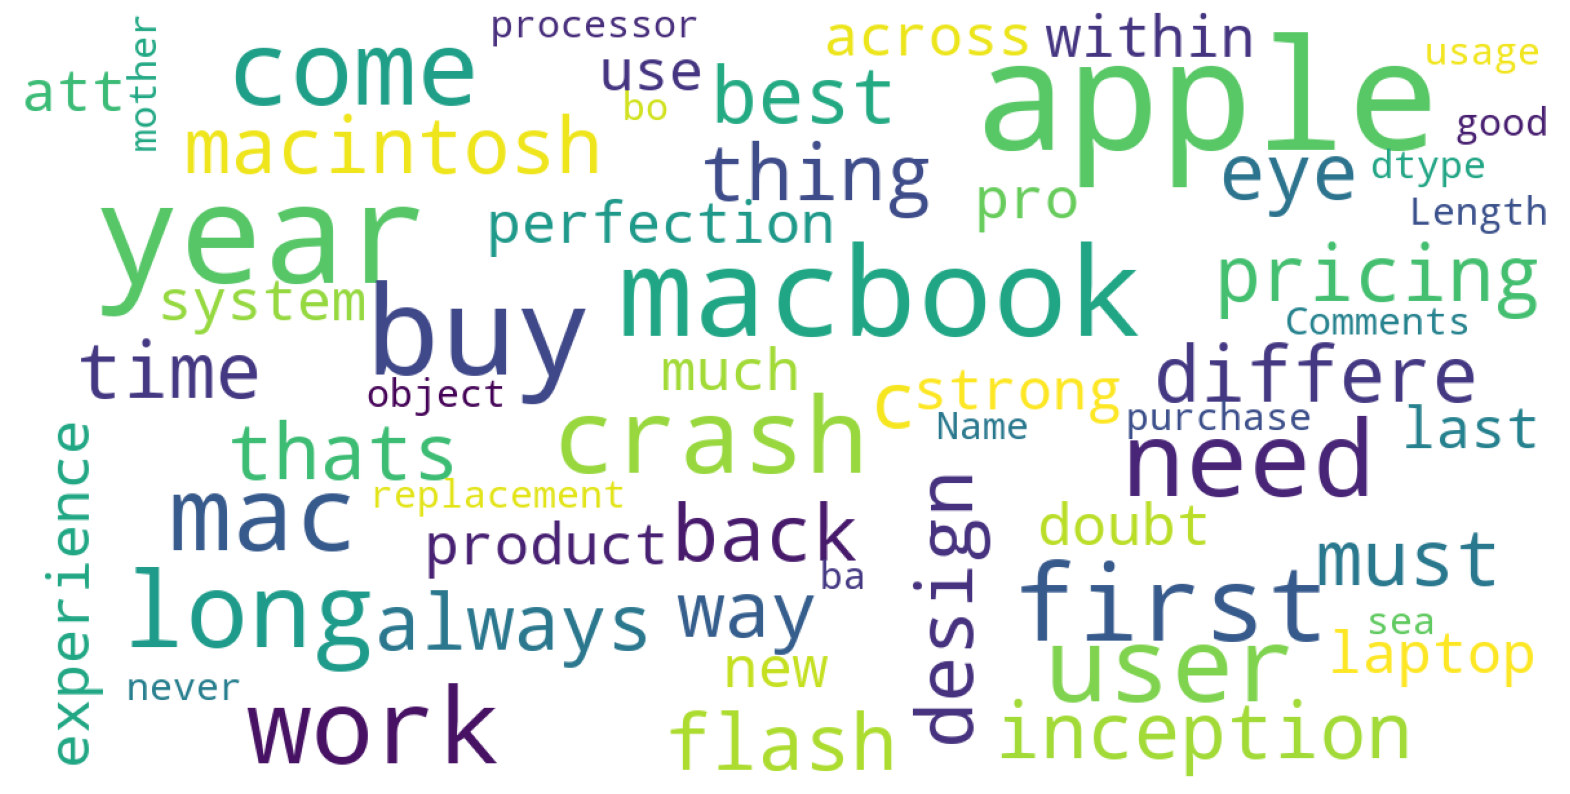

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(df["Comments"])

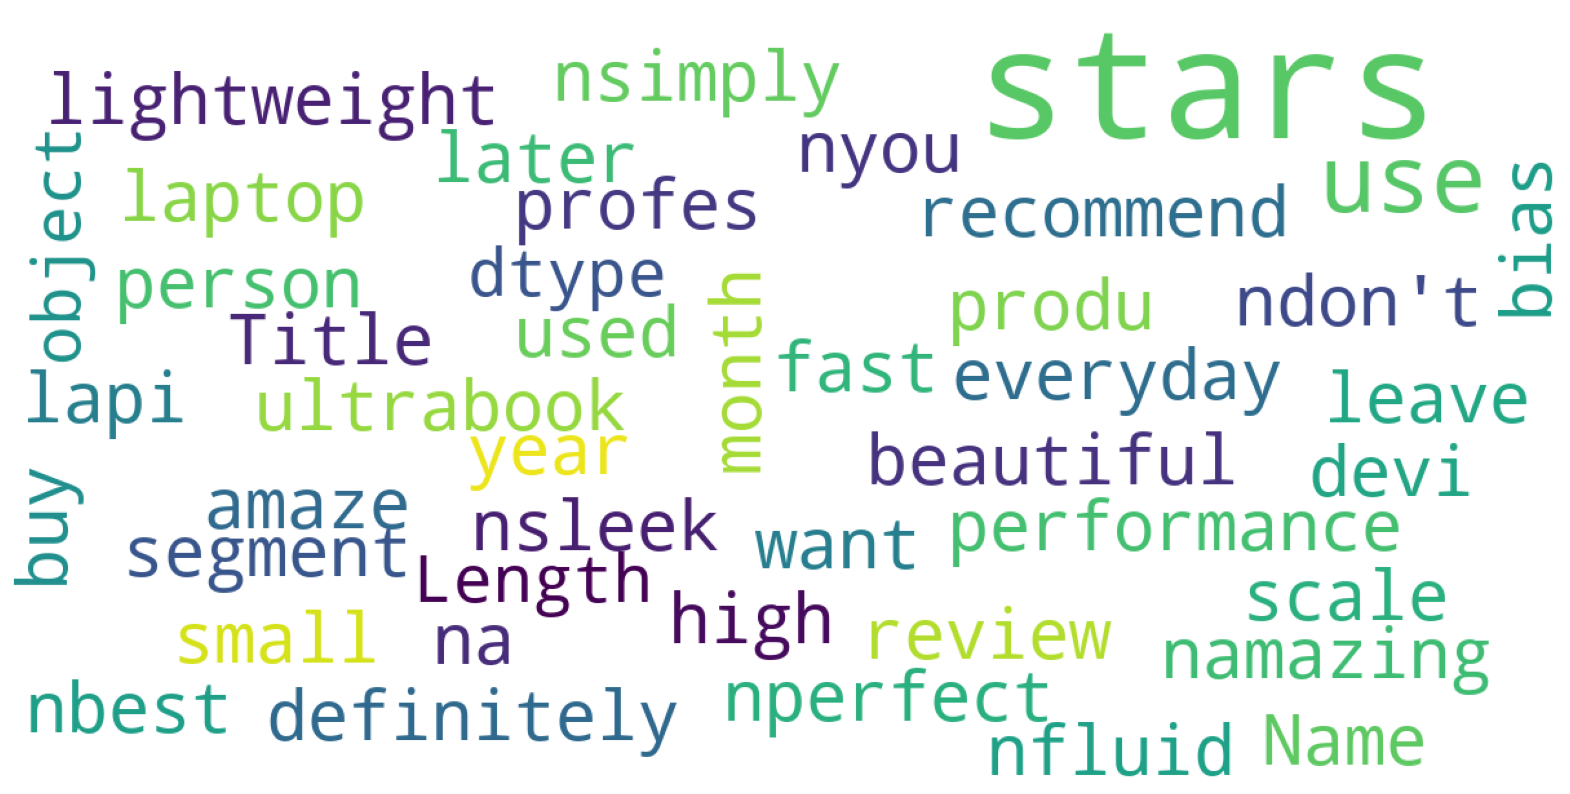

In [18]:
# print wordcloud
show_wordcloud(df["Title"])

In [19]:
df.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_would,word_write,word_wrong,word_yay,word_year,word_years,word_yellow,word_yes,word_yoga,word_yourself
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28,0.040,0.698,0.262,0.9984,2720,391,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15,0.074,0.638,0.288,0.9970,1626,251,...,0.0,0.0,0.063257,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Comments", "pos"]].head(10)

,Comments,pos
371,eye macbook long time pricing best buy differe...,0.288
641,eye macbook long time pricing best buy differe...,0.288
491,eye macbook long time pricing best buy differe...,0.288
651,eye macbook long time pricing best buy differe...,0.288
141,eye macbook long time pricing best buy differe...,0.288
481,eye macbook long time pricing best buy differe...,0.288
661,eye macbook long time pricing best buy differe...,0.288
341,eye macbook long time pricing best buy differe...,0.288
291,eye macbook long time pricing best buy differe...,0.288
71,eye macbook long time pricing best buy differe...,0.288


In [21]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Comments", "neg"]].head(10)

,Comments,neg
147,system crash within year replacement mother bo...,0.258
377,system crash within year replacement mother bo...,0.258
347,system crash within year replacement mother bo...,0.258
727,system crash within year replacement mother bo...,0.258
227,system crash within year replacement mother bo...,0.258
357,system crash within year replacement mother bo...,0.258
67,system crash within year replacement mother bo...,0.258
777,system crash within year replacement mother bo...,0.258
367,system crash within year replacement mother bo...,0.258
557,system crash within year replacement mother bo...,0.258


In [22]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_wrong,word_yay,word_year,word_years,word_yellow,word_yes,word_yoga,word_yourself,Month,Year
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28,0.040,0.698,0.262,0.9984,2720,391,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2017
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15,0.074,0.638,0.288,0.9970,1626,251,...,0.063257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,2017


In [23]:
df_recent = df[(df['Year']== 2020) & (df['Month'] != 8)]
df_recent.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_wrong,word_yay,word_year,word_years,word_yellow,word_yes,word_yoga,word_yourself,Month,Year
8,stars\nyou want leave,4.0,purchase year good usage work buy processor ba...,2020-09-27,0.075,0.73,0.195,0.9732,1083,162,...,0.0,0.0,0.18796,0.0,0.080802,0.063931,0.080802,0.080802,9,2020
18,stars\nyou want leave,4.0,purchase year good usage work buy processor ba...,2020-09-27,0.075,0.73,0.195,0.9732,1083,162,...,0.0,0.0,0.18796,0.0,0.080802,0.063931,0.080802,0.080802,9,2020


# EDA Data Overview

In [24]:
# Display the first few rows of the dataset
df.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_wrong,word_yay,word_year,word_years,word_yellow,word_yes,word_yoga,word_yourself,Month,Year
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28,0.040,0.698,0.262,0.9984,2720,391,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2017
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15,0.074,0.638,0.288,0.9970,1626,251,...,0.063257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,2017


In [25]:
# Get a summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860 entries, 0 to 859
Columns: 909 entries, Title to Year
dtypes: datetime64[ns](1), float32(5), float64(897), int64(4), object(2)
memory usage: 5.9+ MB


In [26]:
# Describe the numerical columns
df.describe()

,Ratings,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,...,word_wrong,word_yay,word_year,word_years,word_yellow,word_yes,word_yoga,word_yourself,Month,Year
count,860.000000,860.000000,860.00000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,...,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000,860.000000
mean,4.300000,0.079200,0.71090,0.209900,0.823720,1323.000000,198.300000,-0.777767,-1.158481,0.727910,...,0.006326,0.005312,0.041930,0.005312,0.008080,0.010596,0.008080,0.008080,6.900000,2018.800000
std,1.188125,0.062382,0.03377,0.079501,0.475315,674.557412,97.214192,0.490139,0.377541,0.460594,...,0.018988,0.015944,0.063335,0.015944,0.024255,0.021763,0.024255,0.024255,2.701571,2.089276
min,1.000000,0.031000,0.63800,0.000000,-0.600300,148.000000,20.000000,-1.946184,-1.759038,-0.055270,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2017.000000
25%,4.000000,0.040000,0.68700,0.176000,0.960700,944.000000,148.000000,-1.139368,-1.424251,0.449115,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2017.000000
50%,5.000000,0.074000,0.72050,0.245500,0.988400,1118.500000,170.000000,-0.679791,-1.220122,0.694070,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2018.500000
75%,5.000000,0.076000,0.74200,0.262000,0.996900,1626.000000,251.000000,-0.369306,-1.037737,0.907476,...,0.000000,0.000000,0.050720,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,2020.000000
max,5.000000,0.258000,0.74800,0.288000,0.998400,2720.000000,391.000000,-0.073526,-0.042567,1.978994,...,0.063257,0.053117,0.187960,0.053117,0.080802,0.063931,0.080802,0.080802,10.000000,2024.000000


# Clean the Data

In [27]:
# Convert Ratings to numeric, forcing any errors to NaN
df['Ratings'] = pd.to_numeric(df['Ratings'], errors='coerce')

# Drop rows with NaN ratings
df = df.dropna(subset=['Ratings'])

# Ensure Ratings is a float type
df['Ratings'] = df['Ratings'].astype(float)

# Check for missing values
df.isnull().sum()


Title            0
Ratings          0
Comments         0
Date             0
neg              0
                ..
word_yes         0
word_yoga        0
word_yourself    0
Month            0
Year             0
Length: 909, dtype: int64

In [28]:
import re
import string

def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+", " ", text)
    text = re.sub('[''""...]', '', text)
    return text


In [29]:
# Apply the clean_text function to the 'Comments' column
df['Comments'] = df['Comments'].apply(lambda x: clean_text(x) if isinstance(x, str) else x)

# Verify the changes
df['Comments'].head()


0    macintosh come long way since inception back c...
1    eye macbook long time pricing best buy differe...
2    appleappleapple thats first thing must flash m...
3    apple always design perfection doubt macbook a...
4    ive strong apple product user since ive use ma...
Name: Comments, dtype: object

# Distribution of Ratings

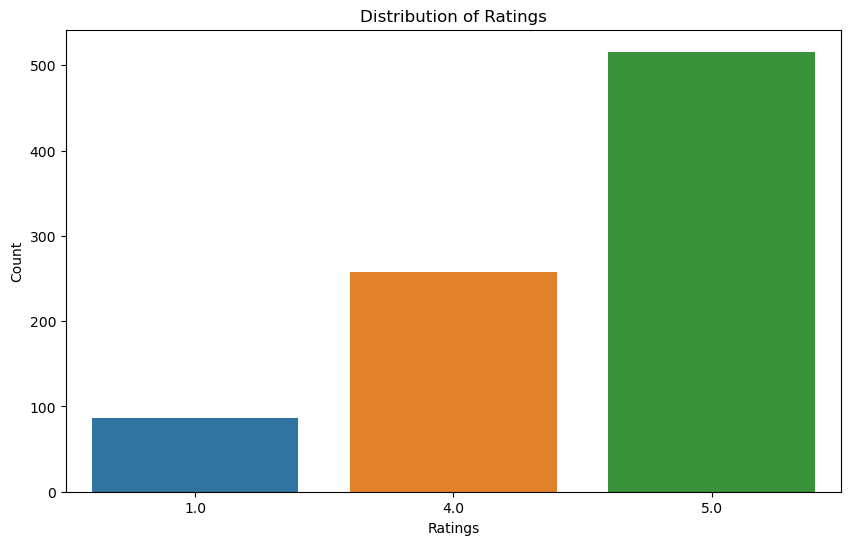

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of Ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='Ratings', data=df)
plt.title('Distribution of Ratings')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


# Distribution of Ratings

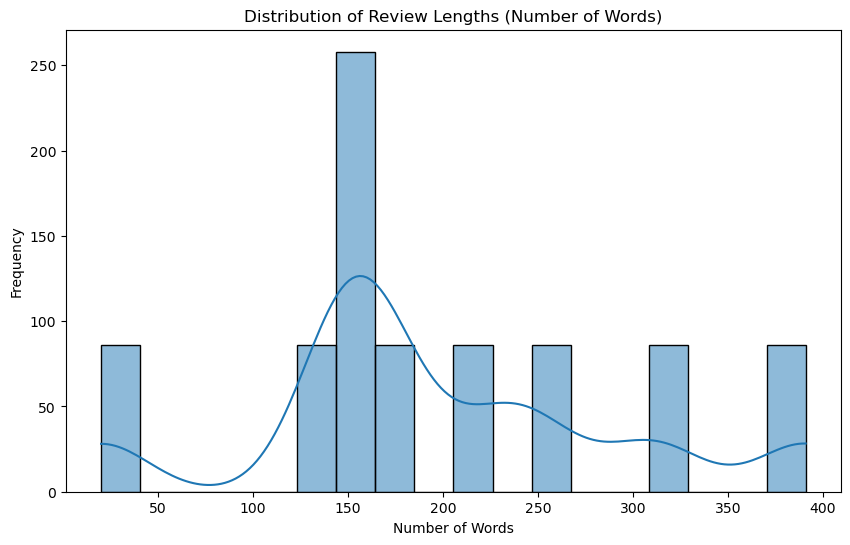

In [31]:
# Review Length Analysis
df['nb_chars'] = df['Comments'].apply(len)
df['nb_words'] = df['Comments'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['nb_words'], kde=True)
plt.title('Distribution of Review Lengths (Number of Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


# Review Length Analysis

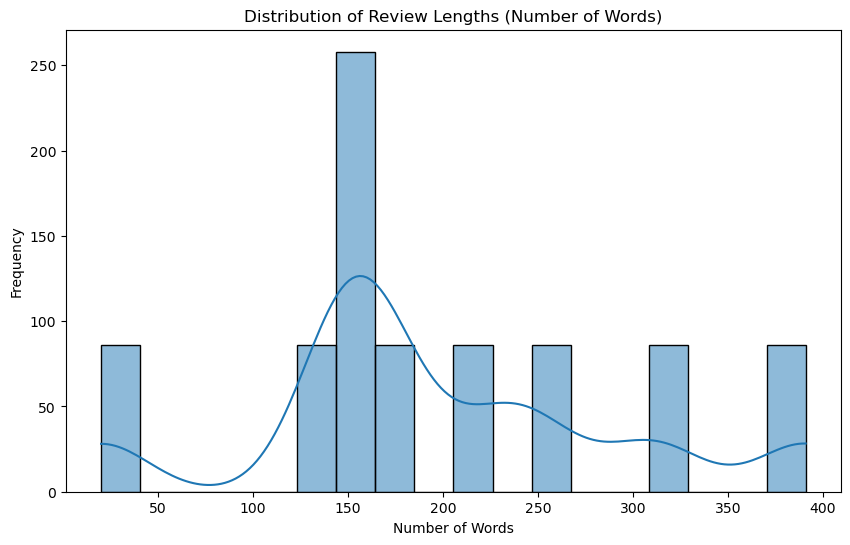

In [32]:
# Review Length Analysis
df['nb_chars'] = df['Comments'].apply(len)
df['nb_words'] = df['Comments'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['nb_words'], kde=True)
plt.title('Distribution of Review Lengths (Number of Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


# Sentiment Analysis 

In [33]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

# Apply sentiment analysis on comments
df['sentiments'] = df['Comments'].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)

# Display first few rows with sentiment scores
df.head()


,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_yellow,word_yes,word_yoga,word_yourself,Month,Year,neg,neu,pos,compound
0,stars\nsleek lightweight high performance devi...,5.0,macintosh come long way since inception back c...,2017-09-28,0.040,0.698,0.262,0.9984,2711,391,...,0.0,0.000000,0.0,0.0,9,2017,0.040,0.698,0.262,0.9984
1,stars\nsimply amaze definitely recommend produ...,5.0,eye macbook long time pricing best buy differe...,2017-08-15,0.074,0.638,0.288,0.9970,1606,251,...,0.0,0.000000,0.0,0.0,8,2017,0.074,0.640,0.286,0.9968
2,stars\na bias review person used month,4.0,appleappleapple thats first thing must flash m...,2019-03-30,0.037,0.715,0.248,0.9969,2056,311,...,0.0,0.042027,0.0,0.0,3,2019,0.037,0.716,0.247,0.9969
3,stars\nperfect everyday use small scale profes...,5.0,apple always design perfection doubt macbook a...,2017-10-31,0.045,0.687,0.268,0.9963,1542,225,...,0.0,0.000000,0.0,0.0,10,2017,0.045,0.687,0.268,0.9963
4,stars\namazing ultrabook laptop segment,5.0,ive strong apple product user since ive use ma...,2017-09-25,0.076,0.748,0.176,0.9607,977,154,...,0.0,0.000000,0.0,0.0,9,2017,0.076,0.748,0.176,0.9607


# Visualize the distribution of sentiment scores.

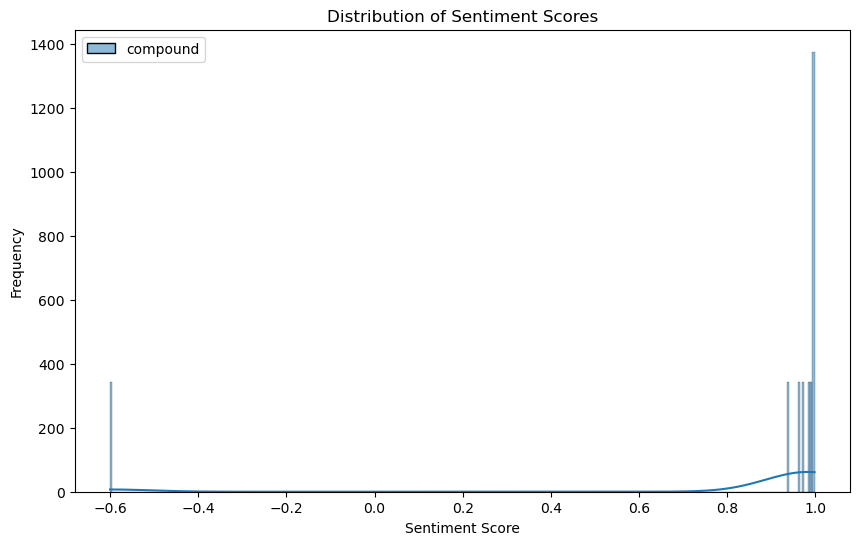

In [34]:
# Visualize the sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['compound'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


# Word Cloud

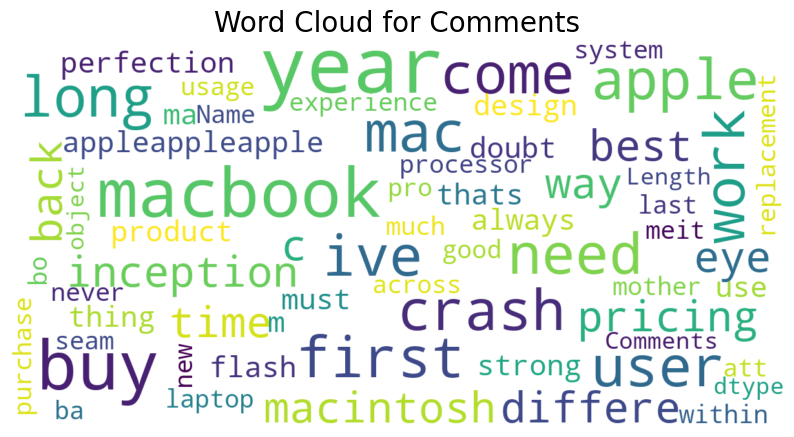

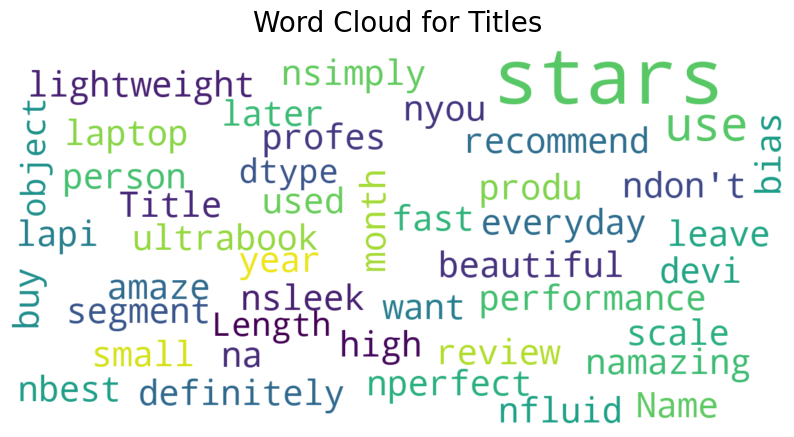

In [35]:
from wordcloud import WordCloud

def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=42
    ).generate(str(data))

    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)
    plt.show()

# Display word cloud for comments
show_wordcloud(df['Comments'], title='Word Cloud for Comments')

# Display word cloud for titles
show_wordcloud(df['Title'], title='Word Cloud for Titles')


# Time-Based Analysis

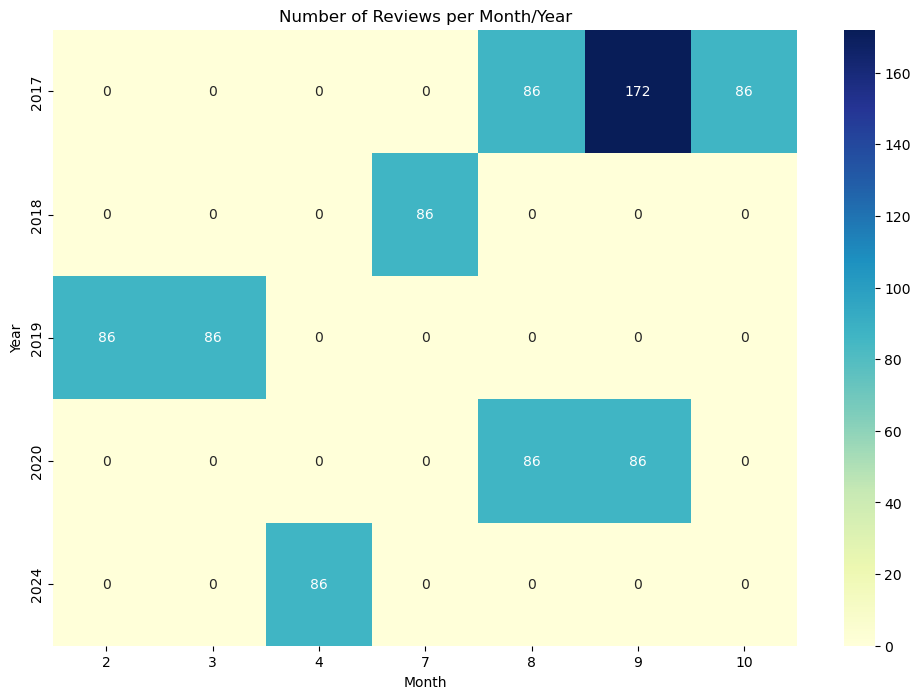

In [36]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

# Reviews per month/year
reviews_per_month = df.groupby(['Year', 'Month']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(reviews_per_month, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Number of Reviews per Month/Year')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()


# Model Building and Evaluation

# Import Models

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import re
import string

# Inspect Dataset

In [38]:
# Check the columns in the DataFrame
print("Columns in the dataset:", df.columns)

# Clean the column names by stripping leading/trailing spaces
df.columns = df.columns.str.strip()

# Print the cleaned columns to verify
print("Cleaned columns in the dataset:", df.columns)


Columns in the dataset: Index(['Title', 'Ratings', 'Comments', 'Date', 'neg', 'neu', 'pos', 'compound',
       'nb_chars', 'nb_words',
       ...
       'word_yellow', 'word_yes', 'word_yoga', 'word_yourself', 'Month',
       'Year', 'neg', 'neu', 'pos', 'compound'],
      dtype='object', length=913)
Cleaned columns in the dataset: Index(['Title', 'Ratings', 'Comments', 'Date', 'neg', 'neu', 'pos', 'compound',
       'nb_chars', 'nb_words',
       ...
       'word_yellow', 'word_yes', 'word_yoga', 'word_yourself', 'Month',
       'Year', 'neg', 'neu', 'pos', 'compound'],
      dtype='object', length=913)


# Preprocess the Date Column

In [39]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

# Drop rows with missing 'Date' values
df.dropna(subset=['Date'], inplace=True)

# Extract the year and month from the 'Date' column
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

#  Select Features and Handle Missing Values

In [40]:
# Ensure all feature names are unique
features_list = ['neg', 'neu', 'pos', 'compound', 'nb_chars', 'nb_words', 'Month', 'Year']

# Remove any duplicate columns if they exist
df = df.loc[:,~df.columns.duplicated()]

# Select features and labels
features = df[features_list]
labels = df['Ratings']

# Handle missing values in features if any
features = features.apply(lambda x: x.fillna(x.mean()), axis=0)


In [41]:
features

,neg,neu,pos,compound,nb_chars,nb_words,Month,Year
0,0.040,0.698,0.262,0.9984,2711,391,9,2017
1,0.074,0.638,0.288,0.9970,1606,251,8,2017
2,0.037,0.715,0.248,0.9969,2056,311,3,2019
3,0.045,0.687,0.268,0.9963,1542,225,10,2017
4,0.076,0.748,0.176,0.9607,977,154,9,2017
...,...,...,...,...,...,...,...,...
855,0.082,0.747,0.171,0.9382,933,148,7,2018
856,0.074,0.678,0.248,0.9913,1151,178,2,2019
857,0.258,0.742,0.000,-0.6003,143,20,4,2024
858,0.075,0.730,0.195,0.9732,1075,162,9,2020


# Define and Apply Clean Text Function to 'Comments' Column

In [42]:
# Define the clean text function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation, and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub("[0-9" "]+", " ", text)
    text = re.sub('[''""...]', '', text)
    return text

# Apply the clean_text function to the 'Comments' column
df['Comments'] = df['Comments'].apply(lambda x: clean_text(x) if isinstance(x, str) else x)

# Verify the changes
print(df['Comments'].head())


0    macintosh come long way since inception back c...
1    eye macbook long time pricing best buy differe...
2    appleappleapple thats first thing must flash m...
3    apple always design perfection doubt macbook a...
4    ive strong apple product user since ive use ma...
Name: Comments, dtype: object


# Convert Text to TF-IDF Features

In [43]:
# the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=100)  # You can adjust the number of features

# Fit and transform the 'Comments' column
if 'Comments' in df.columns:
    tfidf_features = tfidf.fit_transform(df['Comments'].astype('str')).toarray()
else:
    raise KeyError("The 'Comments' column is not found in the dataset. Please check the column name.")

# Create a DataFrame from the TF-IDF features
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf.get_feature_names_out())

# Reset the index of the features DataFrame and combine it with the TF-IDF features
features.reset_index(drop=True, inplace=True)
tfidf_df.reset_index(drop=True, inplace=True)
combined_features = pd.concat([features, tfidf_df], axis=1)


In [44]:
combined_features

,neg,neu,pos,compound,nb_chars,nb_words,Month,Year,adapter,air,...,think,though,time,update,usb,use,video,well,work,year
0,0.040,0.698,0.262,0.9984,2711,391,9,2017,0.000000,0.255211,...,0.090973,0.000000,0.040595,0.000000,0.000000,0.032875,0.000000,0.102940,0.000000,0.000000
1,0.074,0.638,0.288,0.9970,1606,251,8,2017,0.000000,0.037475,...,0.093508,0.215931,0.041726,0.431863,0.105808,0.033790,0.000000,0.105808,0.000000,0.000000
2,0.037,0.715,0.248,0.9969,2056,311,3,2019,0.000000,0.070969,...,0.000000,0.204466,0.039511,0.000000,0.050095,0.031996,0.265628,0.200379,0.177424,0.000000
3,0.045,0.687,0.268,0.9963,1542,225,10,2017,0.000000,0.212660,...,0.000000,0.000000,0.000000,0.000000,0.120087,0.115052,0.159191,0.000000,0.467852,0.000000
4,0.076,0.748,0.176,0.9607,977,154,9,2017,0.095774,0.059005,...,0.147231,0.000000,0.065700,0.000000,0.083299,0.053204,0.000000,0.000000,0.118010,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
855,0.082,0.747,0.171,0.9382,933,148,7,2018,0.108766,0.134019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.302109,0.167204,0.094599,0.067009,0.000000
856,0.074,0.678,0.248,0.9913,1151,178,2,2019,0.000000,0.106342,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066337,0.000000,0.053171,0.075063
857,0.258,0.742,0.000,-0.6003,143,20,4,2024,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.619451
858,0.075,0.730,0.195,0.9732,1075,162,9,2020,0.173668,0.000000,...,0.066744,0.000000,0.178702,0.000000,0.000000,0.144714,0.000000,0.000000,0.160492,0.302095


# Split the Data

In [45]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.2, random_state=42)

# Train and Evaluate Models

In [46]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

results = {}

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[name] = {'MSE': mse, 'R2': r2}

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T

print(results_df)

                            MSE   R2
Linear Regression  3.038055e-25  1.0
Decision Tree      0.000000e+00  1.0
Random Forest      0.000000e+00  1.0
Gradient Boosting  9.561479e-10  1.0
XGBoost            1.503220e-09  1.0


# Determine the Best Model

In [48]:
best_model_name = results_df['MSE'].idxmin()

print(f"The best model based on MSE is: {best_model_name}")

The best model based on MSE is: Decision Tree
